In [1]:
1+1

2

In [2]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# !pip install --quiet tensorflow-hub
# !pip install --quiet seaborn

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0402 22:53:11.388453 140350233954112 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

In [4]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

## Load the data

In [5]:
main_dir = '/home/yulia/'

In [6]:
data_path = main_dir+'final-project/data/raw/hein-daily'

In [7]:
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [8]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1090182100
date 20061114
char_count 278
word_count 49
speakerid 109112991.0
Party R
Congress 109
Chamber S
State TN
Ethnicity W
Age 54.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. FRIST
Full Name FRIST, WILLIAM
match exact
check 1

It took 23.7 seconds to create the dictionary


In [9]:
gender = load_data.create_target_labels(all_speech_ids, descr)[0]
len(gender)

3866201

In [10]:
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 94074 ones and 94074 zeroes
Training speech list size: 188148
Training target list size: 188148
Validation split: 31358 ones and 31358 zeroes
Validation speech list size: 62716
Validation target list size: 62716
Test split: 31358 ones and 31358 zeroes
Test speech list size: 62716
Test target list size: 62716


In [11]:
del descr, all_speech_ids, all_speeches, test, test_ids, test_target

In [22]:
gc.collect()

0

### Split it in chunks

In [14]:
chunk_len=30

In [15]:
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)

Original data has 188148 speeches
It was split into 2541572 chunks
Checks on ids and target 2541572 2541572
Original target mean 0.5
New target mean 0.5144335867722811
Original data has 62716 speeches
It was split into 851633 chunks
Checks on ids and target 851633 851633
Original target mean 0.5
New target mean 0.5181163717235007


### Load processed data with sentence embeddings (processed during MLP stage)

In [16]:
outdata_path = main_dir+'final-project/Classification/data'

In [84]:
with open(os.path.join(outdata_path, 'train_emb30'), 'rb') as fp:
    train_emb = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_emb30_p2'), 'rb') as fp:
    train_emb2 = pickle.load(fp)

In [85]:
train_emb = np.concatenate((train_emb, train_emb2), axis=0)
train_emb.shape

(2541572, 512)

In [19]:
with open(os.path.join(outdata_path, 'val_emb30'), 'rb') as fp:
    val_emb = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_emb30_p2'), 'rb') as fp:
    val_emb2 = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_emb30_p3'), 'rb') as fp:
    val_emb3 = pickle.load(fp)

In [20]:
val_emb = np.concatenate((val_emb, val_emb2, val_emb3), axis=0)
val_emb.shape

(851633, 512)

In [23]:
del train_emb2, val_emb2, val_emb3

In [87]:
gc.collect()

210

In [25]:
len(train_ids)

188148

### Reshape the data for CNN

In [72]:
gc.collect()

639

In [49]:
def reshape_chunked_speech(data_emb, ids, ids_chunk, target, max_num_chunks=25, emb_dim=100):
    
    id_dict = {k:[] for k in ids} 
    for i in range(len(ids_chunk)):
        if ids_chunk[i] in id_dict:
            id_dict[ids_chunk[i]].append(data_emb[i][:emb_dim]) 
    
    data_list, new_ids = [], []
    for speech_id in id_dict:
        new_ids.append(speech_id)
        chunks = id_dict[speech_id].copy()
        if len(chunks) < max_num_chunks:
            padding = (max_num_chunks - len(id_dict[speech_id])) * [[0]*emb_dim]
            chunks.extend(padding)
            data_list.append(chunks)
        else:
            data_list.append(chunks[:max_num_chunks])    
    
    del id_dict
    
    data_list_flat = list(itertools.chain.from_iterable(data_list))
    data_array = np.reshape(np.array(data_list_flat), [len(ids), -1, emb_dim])
    print("Input data shape:", data_array.shape)
    
    new_target = [target[ids.index(new_ids[i])] for i in range(len(ids))]
    print("Target shape", len(new_target))
    
    return data_array, new_target, new_ids

In [75]:
def reshape_batches(data_emb, ids, ids_chunk, target, batch_size=10, n_chunks=25, e_dim=100):
    
    batches = list(range(0, len(ids), int(len(ids)/batch_size)))
    
    data_vec = np.empty([0,n_chunks,e_dim])
    target_vec, ids_vec = [], []
    for i in range(len(batches)):
        start_time = time.time()
        if i < len(batches) - 1:
            data_batch, target_batch, ids_batch = reshape_chunked_speech(data_emb, ids[batches[i]:batches[i+1]], ids_chunk, target[batches[i]:batches[i+1]], n_chunks, e_dim)
        if i == len(batches) - 1:
            data_batch, target_batch, ids_batch = reshape_chunked_speech(data_emb, ids[batches[i]:], ids_chunk, target[batches[i]:], n_chunks, e_dim)
        data_vec = np.concatenate((data_vec, data_batch), axis=0)
        target_vec.extend(target_batch)
        ids_vec.extend(ids_batch)
        print("It took {:.1f} seconds to process the batch {}\n".format(time.time()-start_time, i+1))     
    
    return data_vec, target_vec, ids_vec

In [88]:
n_chunks = 25
e_dim = 100
batch_size = 10

train_vec, train_target_vec, train_ids_vec = reshape_batches(train_emb, train_ids, train_ids_chunk, train_target, batch_size, n_chunks, e_dim)

Input data shape: (18814, 25, 100)
Target shape 18814
It took 12.4 seconds to process the batch 1

Input data shape: (18814, 25, 100)
Target shape 18814
It took 12.9 seconds to process the batch 2

Input data shape: (18814, 25, 100)
Target shape 18814
It took 12.5 seconds to process the batch 3

Input data shape: (18814, 25, 100)
Target shape 18814
It took 13.1 seconds to process the batch 4

Input data shape: (18814, 25, 100)
Target shape 18814
It took 12.6 seconds to process the batch 5

Input data shape: (18814, 25, 100)
Target shape 18814
It took 14.4 seconds to process the batch 6

Input data shape: (18814, 25, 100)
Target shape 18814
It took 14.3 seconds to process the batch 7

Input data shape: (18814, 25, 100)
Target shape 18814
It took 14.1 seconds to process the batch 8

Input data shape: (18814, 25, 100)
Target shape 18814
It took 14.8 seconds to process the batch 9

Input data shape: (18814, 25, 100)
Target shape 18814
It took 14.6 seconds to process the batch 10

Input dat

In [89]:
train_vec.shape, len(train_target_vec), len(train_ids_vec)

((188148, 25, 100), 188148, 188148)

In [90]:
len(train), len(train_target), len(train_ids)

(188148, 188148, 188148)

In [91]:
sum(train_target_vec), sum(train_target)

(94074, 94074)

In [92]:
del train_emb

In [93]:
gc.collect()

0

In [76]:
n_chunks = 25
e_dim = 100
batch_size = 4

val_vec, val_target_vec, val_ids_vec = reshape_batches(val_emb, val_ids, val_ids_chunk, val_target, batch_size, n_chunks, e_dim)

Input data shape: (15679, 25, 100)
Target shape 15679
It took 9.2 seconds to process the batch 1

Input data shape: (15679, 25, 100)
Target shape 15679
It took 8.8 seconds to process the batch 2

Input data shape: (15679, 25, 100)
Target shape 15679
It took 10.1 seconds to process the batch 3

Input data shape: (15679, 25, 100)
Target shape 15679
It took 9.6 seconds to process the batch 4



In [77]:
val_vec.shape, len(val_target_vec), len(val_ids_vec)

((62716, 25, 100), 62716, 62716)

In [78]:
len(val), len(val_target), len(val_ids)

(62716, 62716, 62716)

In [80]:
sum(val_target_vec), sum(val_target)

(31358, 31358)

In [94]:
del val_emb

## CNN Model

In [64]:
logs_base_dir = main_dir+"final-project/Classification/logs"

In [65]:
cnn_model_params = {
    'model': 'cnn',
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'kernel_size': 5,
    'pool_size': 1
}

In [95]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, np.array(train_target_vec)), (val_vec, np.array(val_target_vec))), logs_base_dir, **cnn_model_params)

Train on 188148 samples, validate on 62716 samples
Epoch 1/1000
 - 32s - loss: 0.6285 - acc: 0.6450 - val_loss: 0.6154 - val_acc: 0.6611
Epoch 2/1000
 - 30s - loss: 0.6144 - acc: 0.6600 - val_loss: 0.6094 - val_acc: 0.6671
Epoch 3/1000
 - 31s - loss: 0.6084 - acc: 0.6669 - val_loss: 0.6085 - val_acc: 0.6663
Epoch 4/1000
 - 31s - loss: 0.6039 - acc: 0.6708 - val_loss: 0.5993 - val_acc: 0.6761
Epoch 5/1000
 - 30s - loss: 0.6005 - acc: 0.6736 - val_loss: 0.6017 - val_acc: 0.6748
Epoch 6/1000
 - 31s - loss: 0.5983 - acc: 0.6764 - val_loss: 0.5947 - val_acc: 0.6786
Epoch 7/1000
 - 30s - loss: 0.5953 - acc: 0.6786 - val_loss: 0.5941 - val_acc: 0.6805
Epoch 8/1000
 - 31s - loss: 0.5936 - acc: 0.6814 - val_loss: 0.5940 - val_acc: 0.6815
Epoch 9/1000
 - 31s - loss: 0.5908 - acc: 0.6827 - val_loss: 0.5962 - val_acc: 0.6787
Epoch 10/1000
 - 32s - loss: 0.5905 - acc: 0.6840 - val_loss: 0.5933 - val_acc: 0.6824
Epoch 11/1000
 - 30s - loss: 0.5884 - acc: 0.6859 - val_loss: 0.5930 - val_acc: 0.6799
E

In [99]:
probs_path = main_dir + 'final-project/Classification/data/cnn/gender'

In [100]:
with open(os.path.join(probs_path, 'val_pred_probs_use'), 'wb') as fp:
    pickle.dump(val_pred_probs, fp)

In [97]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target_vec)

42881

Confusion matrix, without normalization
[[20474 10884]
 [ 8951 22407]]
             precision    recall  f1-score   support

       Male       0.70      0.65      0.67     31358
     Female       0.67      0.71      0.69     31358

avg / total       0.68      0.68      0.68     62716



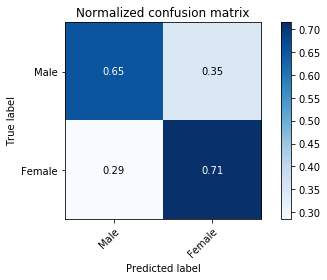

In [98]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target_vec, val_preds, classes, normalize=True)

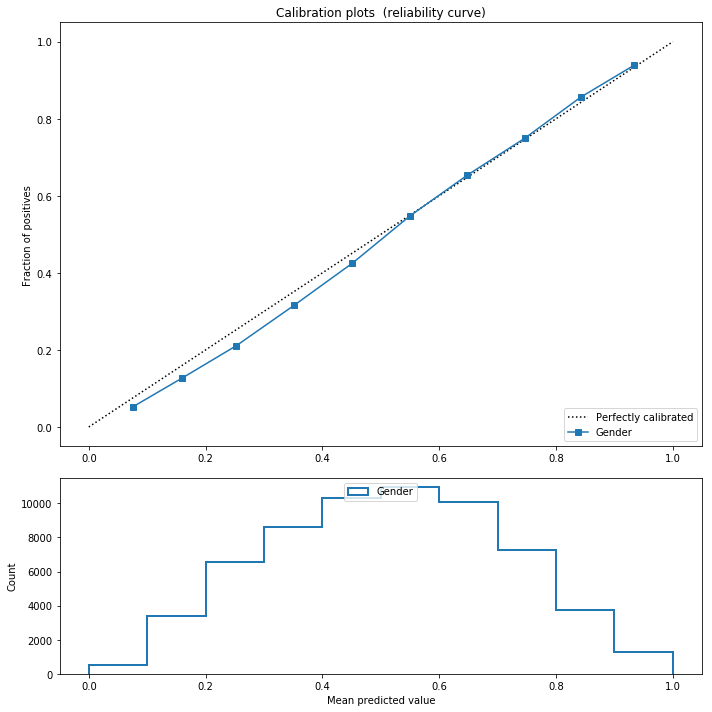

In [101]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target_vec, val_pred_probs, 'Gender')